<a href="https://colab.research.google.com/github/mesnico/DTfH-Laboratory/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory on Image Classification
-----------------

You'll learn to:

*   open and handle images in Python,
*   classify images using a generic closed-set image classifier (ResNet-50),
*   classify images using an open-set classifier (CLIP).

## 0.0 Getting Started with Google Colab

We will use **Google Colab**, a Google service that let you run *Python Notebooks* on their servers without installing anything on your device.

* A Python notebook is a collection of **cells** (text and code) that you can freely modify.

* You can *run code cells* by selecting them and clicking the play button on the left (or pressing `Shift+Enter`).

* To access files from Colab, you have to copy them somehow in the Colab session. **WARNING**: the Colab session is temporary and will be deleted after a period of inactivity.

* You can download and run the code on your PC using `File > Download > Download .py` (you'll need to set up a Python installation and install all the required packages).


***-----> Try Yourself***: add a Code cell below, write a `print()` statement to print `Hello, world!`, and run the cell.

***-----> Try Yourself***: download [this image](https://www.camera-rumors.com/wp-content/uploads/2018/02/sony-a7iii-sample-image-3.jpg), open the Files tab on the right (folder icon), and upload the downloaded image to the Colab session.

## 0.1 Python Refresher

In [ ]:
# this is a comment

In [ ]:
a_string_variable = 'here are some characters'

In [ ]:
a_list = [2, 'hi', 7]
another_list = ['two', 1, 'seven']

In [ ]:
# for loop
for n in a_list:
  print(n)

In [ ]:
# for loop on two list in parallel
for n, m in zip(a_list, another_list):
  print(n, m)

In [ ]:
a_dictionary = {
    0: 'foo',
    4: 'bar',
    'a': 56
}

print(a_dictionary[4])
print(a_dictionary['a'])

## 1. Handling Images in Python

The Python Imaging Library (PIL) adds image processing capabilities to the Python interpreter.

Let's see how to open and display an image with PIL.

In [ ]:
# import the library
import PIL

image_path = '/content/sony-a7iii-sample-image-3.jpg'

# open the image
pil_image = PIL.Image.open(image_path)

# display it on colab (display() is a special Colab function)
display(pil_image)

Neural networks often work on lower resolution images, let's use PIL to resize the image. Let's fit the image in a 300x300 pixels area.

In [ ]:
# resize the image inplace
pil_image.thumbnail((300, 300))

# print the new size
print(pil_image.size)

# show the image
display(pil_image)

Now we need to get the RGB pixel values that comprise the input of our neural networks for classification.

An RGB image have 3 grids of pixels (one for each channel, red, green, and blue). Each pixel in each channel has a value (a number between 0 and 255 usually) that indicate how much color there is at that position.

An image is a **3d-array (or tensor)** of numbers.



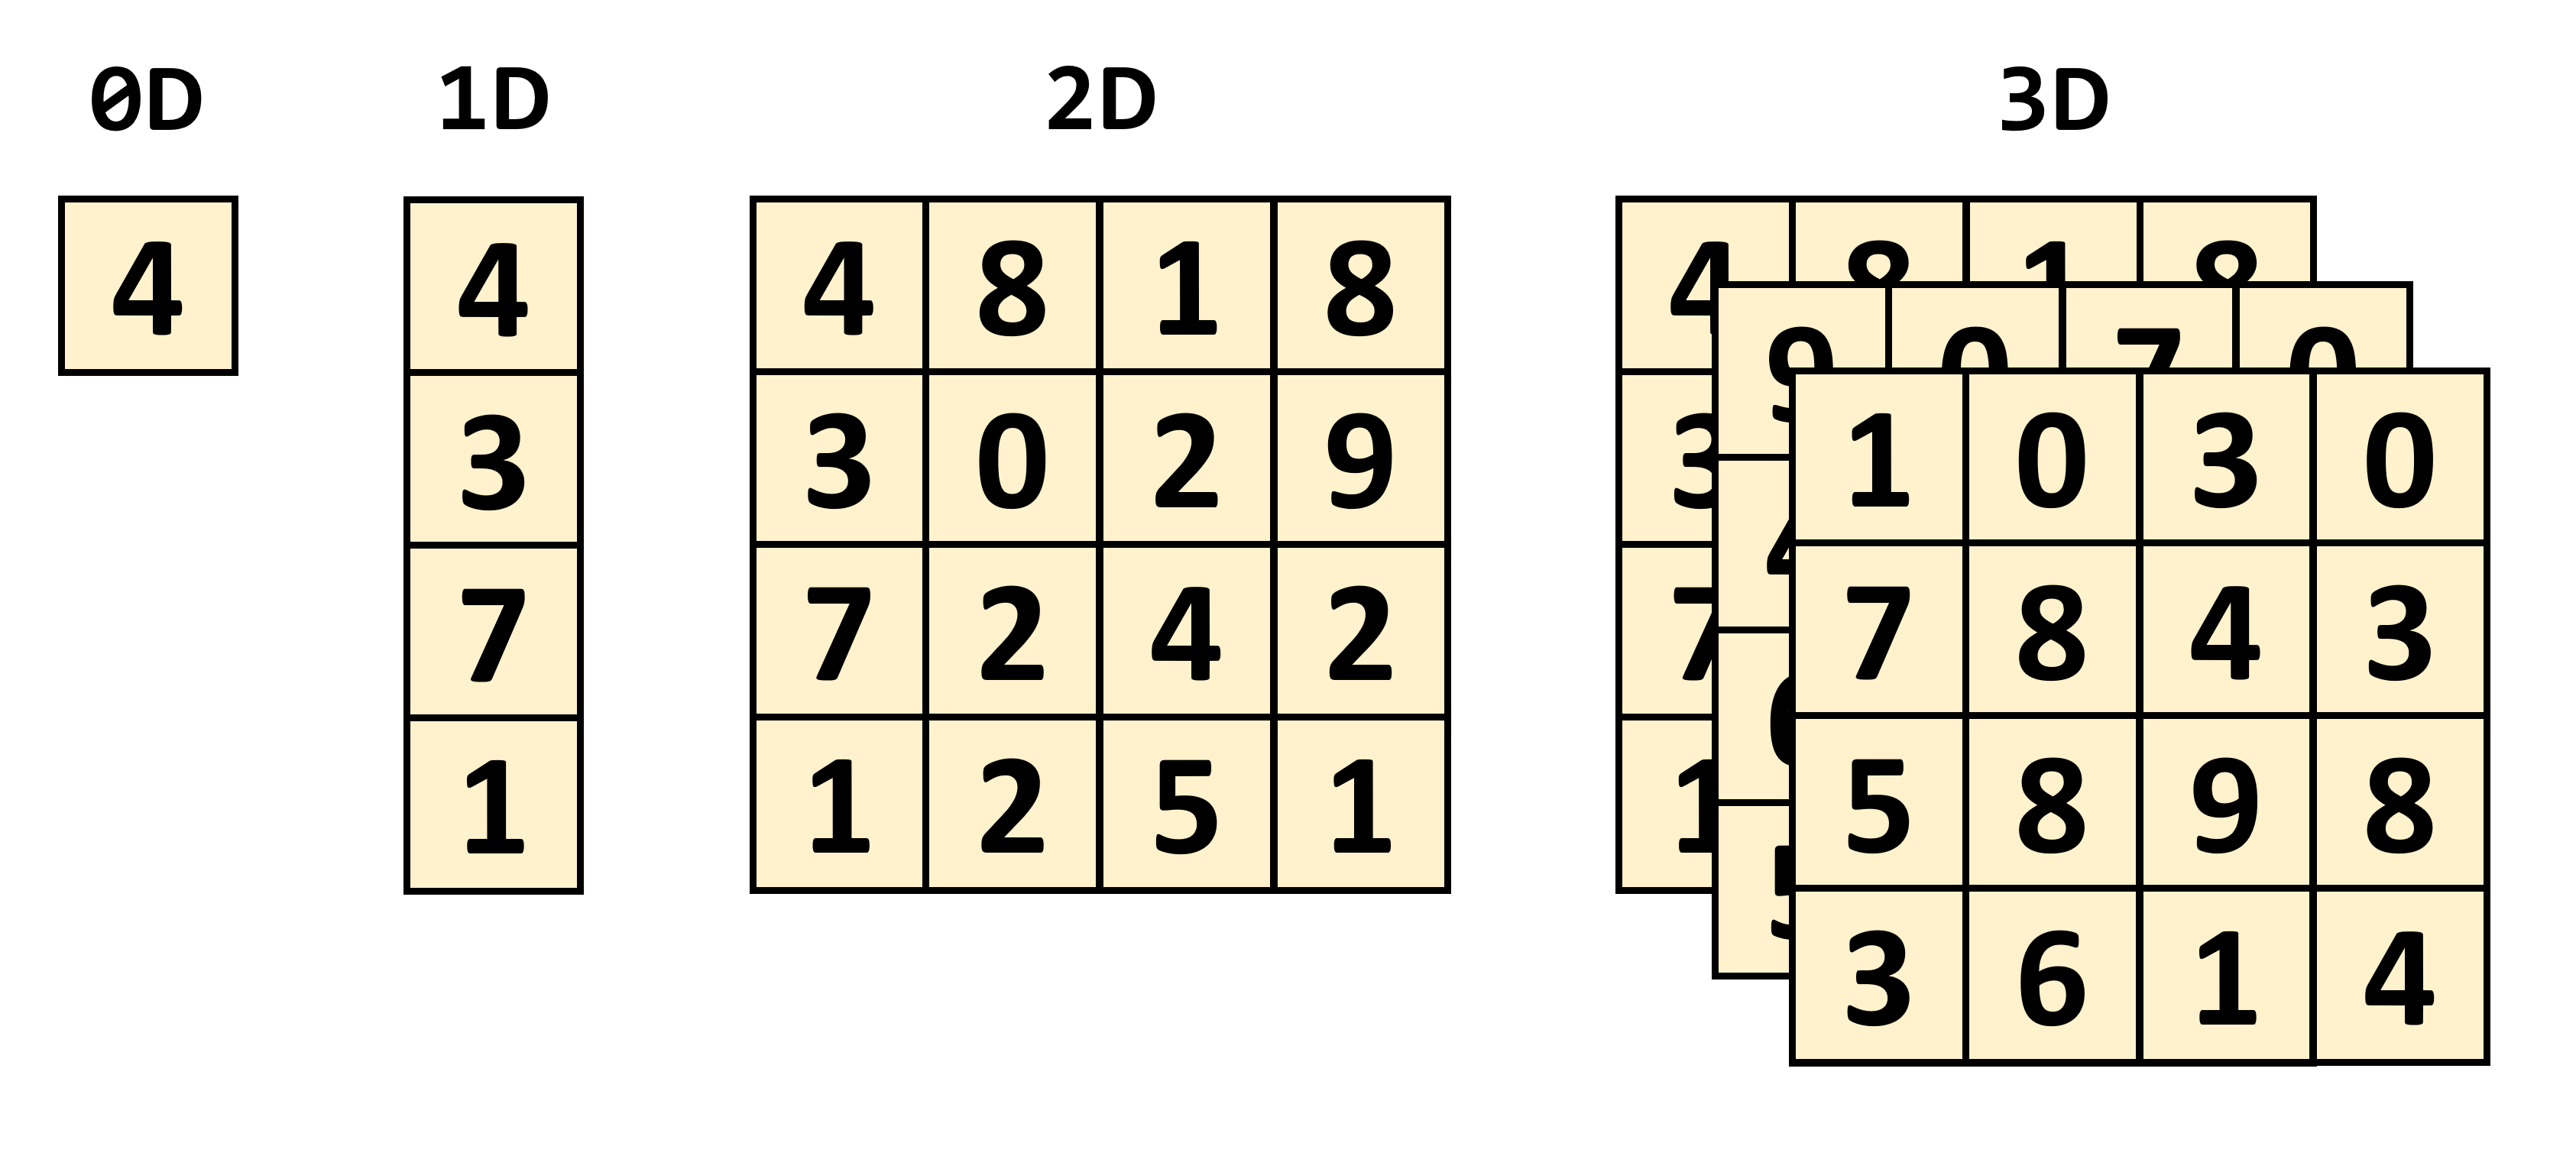

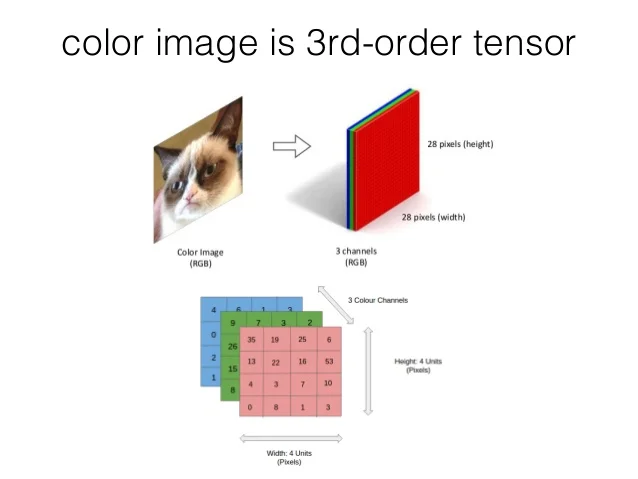

In Python, the NumPy library greatly helps when dealing with numerical data in matrix/tensors.

Let's transform our PIL image in a NumPy tensor and visualize the values.

In [ ]:
import numpy as np

# convert a PIL image in a 3d tensor
numpy_image = np.array(pil_image)

print('tensor shape:', numpy_image.shape)

# : = all rows
# : = all columns
# 2 = third channel (blue one)
blue_channel = numpy_image[:, :, 2]

print('blue_channel shape:', blue_channel.shape)

# print all numbers in a grid
with np.printoptions(threshold=10**6, linewidth=10**6):
  print(blue_channel)

## 2. Classification with a Pretrained Model (closed-set)

Next, we will use a pretrained neural network to label this image.

The neural network we will use is a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224), one of the most recent networks for processing image data.

We will load a classifier already trained to recognize 1,000 categories of generic objects belonging to the ImageNet-1k dataset.

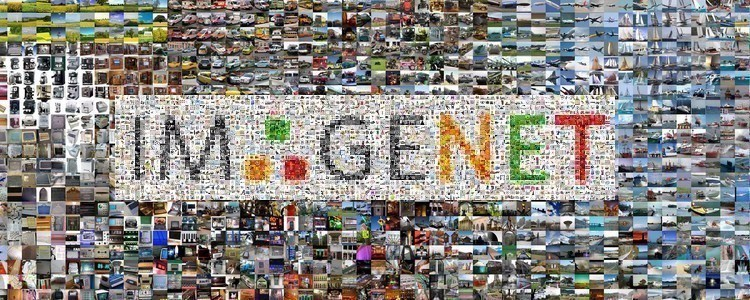

There are several model hubs online that provides already trained models for a variety of tasks.

***NOTE***: Probably the specific task you are searching for is not available on public model repositories (e.g., pretrained classification models could not include the category you are interest in), but those models can be trained again to be fine-tuned for a specific task.

We will use [Hugging Face](https://huggingface.co/) as model hub; specifically, we will load the `vit-base-patch16-224` model trained by Google. We can load models using the `transformers` library provided by Hugging Face.

In [ ]:
# let's install the library
!pip install transformers

Now, let's obtain the model and the preprocessing pipeline. It may take a while to download the model.

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

preprocess = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

We can access the classes the network is able to discern. Hugging Face classification models provide this info as a Python dictionary:

In [ ]:
 model.config.id2label

Next, we apply the model to our image ... 

In [ ]:
# preprocess our pil image to be compatible with the input of the model
inputs = preprocess(images=pil_image, return_tensors="pt")

# apply the neural network, take the scores (called logits) for each class
outputs = model(**inputs).logits

# take the index of the maximum score
predicted_class_idx = outputs.argmax(-1).item()

# 
predicted_class_label = model.config.id2label[predicted_class_idx]
print("Predicted class:", predicted_class_label)

Instead of printing only the most confident class, we can print the top K:

In [ ]:
topk_scores, topk_indices = outputs.topk(5)

for index in topk_indices.squeeze().tolist():
  print(model.config.id2label[index])

***-----> Try Yourself***: upload other images, modify the code to load the new images, and rerun the classification.

- What labels is the model predicting for your image?
- Can you find an image where the model's prediction is wrong?

## 3. Classification using a Pretrained Model (open-set)

Closed-set classification models are limited to the learnt categories.

Instead of producing the class scores directly, we can use neural networks for **image features extraction**.
We compare extracted features to ***category prototypes*** to check whether they match.

Specifically, we will explore open-set image classification using the [Contrastive Language-Image Pre-training (CLIP)](https://github.com/openai/CLIP) model by OpenAI.

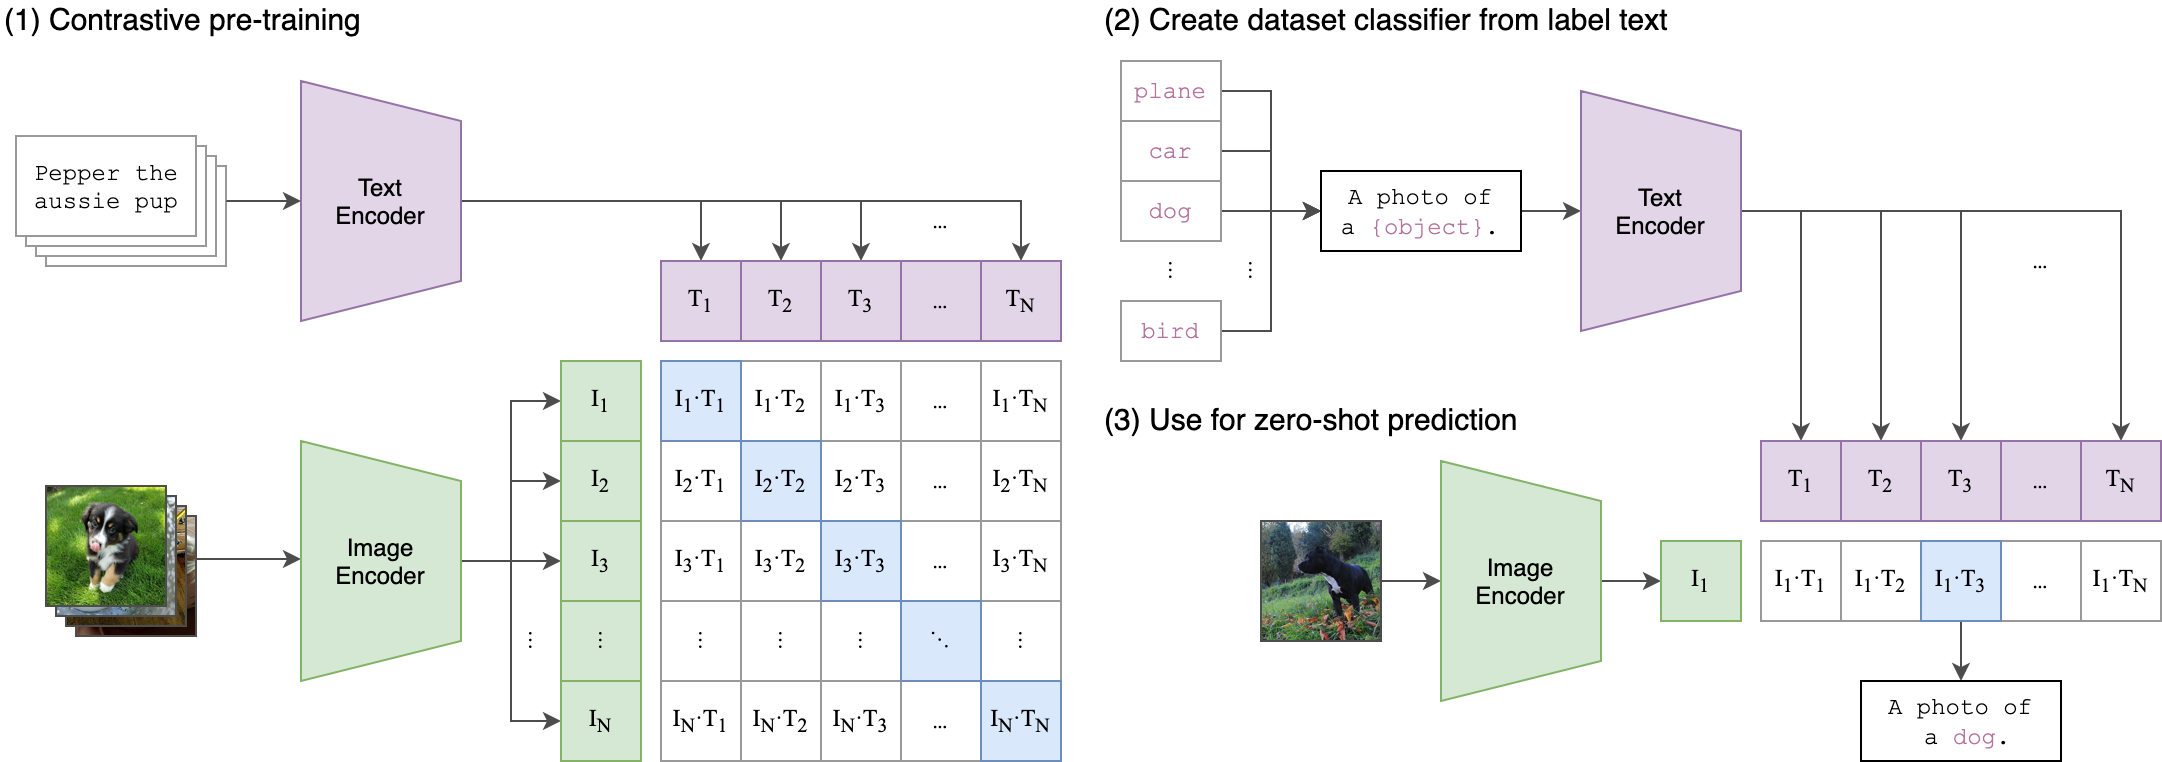

This model is trained

- to extract **representations of images** (image features)
- and **representations of short text sentences** (text features)
- such that those representations **match** when the text describe the image content.

CLIP can be used to match an image to an arbitrary textual description, enabling open-set classification; you can decide the taxonomy you are interest in.

Let's load CLIP from the Hugging Face model hub.

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Let's decide a taxonomy of classes we want to match our image against.

In [ ]:
taxonomy = [
  "a photo of a cat",
  "a photo of a dog",
  "a photo of a fox",
]

Now, let's apply the model and inspect its ouputs.

In [ ]:
# preprocess our pil image and the taxonomy to be compatible with the input of the model
inputs = preprocess(text=taxonomy, images=pil_image, return_tensors="pt", padding=True)

# apply the model
outputs = model(**inputs)

The model provides many useful outputs, such as:

In [ ]:
# the learnt representations for our text sentences (taxonomy)
print(outputs.text_embeds)
print(outputs.text_embeds.shape)

In [ ]:
# the learnt representations for our text sentences (taxonomy)
print(outputs.image_embeds)
print(outputs.image_embeds.shape)

In [ ]:
# the image-text similarity scores
print(outputs.logits_per_image)

In [ ]:
scores = outputs.logits_per_image

# we can take the softmax to get the label probabilities
probs = scores.softmax(dim=1).detach().numpy().squeeze()

for prob, category in zip(probs, taxonomy):
  print(f'{prob:.2%}: {category}')

***-----> Try Yourself***: change the input images, change the taxonomy, and rerun the classification.

- Try to articulate more the categories in the taxonomy (e.g., a red fox with a snowy background). How does the classification changes?
- Explore the limits of the model. Find an image+taxonomy where the model is wrong.

## 4. Utilities

You can load an image into PIL from a URL like this:

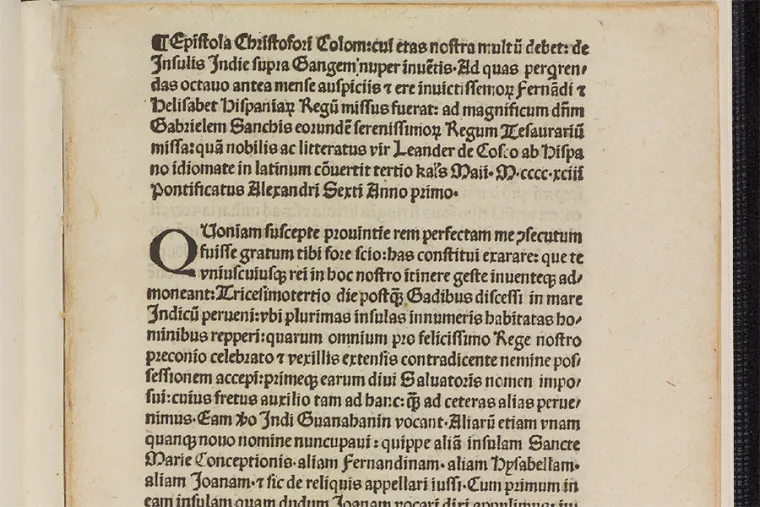

In [22]:
import requests

url = 'https://www.catholicnewsagency.com/images/Authentic_Vatican_Columbus_Letter_Copyright_US_Embassy_CNA.jpg?w=760'

image_data = requests.get(url, stream=True).raw
pil_image = PIL.Image.open(image_data)

display(pil_image)